<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Demonstration using Autoencoder
**Author**: W. Tod Newman

**Updates**: New Release

## Learning Objectives


*   Understand how an autoencoder can be designed/constructed
*   See the capability for denoising an image

In this exercise we're using data from Fashion MNIST to provide more challenging images to work with.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

## Approach of this Module
Trains a denoising autoencoder on Fashion MNIST dataset.
* Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
* Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
* This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.


## First, set up Tensorflow Callbacks

In [ ]:
LR = ReduceLROnPlateau(monitor='val_loss', 
                        patience=2, 
                        verbose=1, 
                        factor=0.3, 
                        min_lr=0.00001)

my_callbacks = [ModelCheckpoint('denoiser.hdf5', monitor='val_loss', save_best_only=True, period=1),LR]


## Set up the Fashion MNIST Dataset

In [ ]:
# Fashion MNIST dataset

(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Reshape to (X,28,28,1) and then scale to values between 0 and 1

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted Fashion MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5

noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise  # add normally distributed noise to x_train
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise # add normally distributed noise to x_test

# Limit values to be between 0 and 1

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

4431872/4422102 [==============================] - 0s 0us/step


## Below we build the Encoder, Decoder, and the Autoencoder

In [ ]:
# Basic parameters
retrain = True
np.random.seed(1337)
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 4
latent_dim = 20 # dimension of the hidden layer

# Encoder/Decoder number of CNN layers and filters per layer

layer_filters = [40, 80]

'''Build the Autoencoder Model'''

#
# Starting with the Encoder Model
#

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1

# FIRST: Two convolutional layers.

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model

shape = K.int_shape(x) # return the shape of x as a tuple of integers

# Flatten out the network.
# Then one dense layer that will compress down to the latent dimension.

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model

encoder = Model(inputs, latent, name='encoder')
encoder.summary()
# ---------------------------------------------------------------------------

#
# Build the Decoder Model
# Inputs to the decoder are of the size of the latent dimension.
# Dense layer uses the shape parameter from the inputs to the encoder.
#

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# ---------------------------------------------------------------------------

#
# Instantiate Autoencoder Model and Fit it
#

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
if not retrain:
    autoencoder = load_model('denoiser.hdf5')
autoencoder.summary()

optimizer=keras.optimizers.Nadam(lr=.001)

autoencoder.compile(loss='mse', optimizer=optimizer)

#
# Train the autoencoder.  x_train functions as the labels for the noisy images
# In the real world, often times all we see is the noisy data.  If we can ever access
# the data before the process inserts the noise, we can build a model to infer the
# "Clean" from the "Noisy".  This is relevant for telecommunications, for example.
#
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                callbacks=my_callbacks,
                epochs=20,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 40)        680       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 80)          51280     
                                                                 
 flatten (Flatten)           (None, 3920)              0         
                                                                 
 latent_vector (Dense)       (None, 20)                78420     
                                                                 
Total params: 130,380
Trainable params: 130,380
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/20
469/469 [==============================] - 19s 12ms/step - loss: 0.0440 - val_loss: 0.0248 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0227 - val_loss: 0.0205 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0198 - val_loss: 0.0204 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0184 - val_loss: 0.0182 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0175 - val_loss: 0.0178 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0169 - val_loss: 0.0170 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0164 - val_loss: 0.0164 - lr: 0.0010
Epoch 8/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0160 - val_loss: 0.0166 - lr: 0.0010
Epoch 9/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0156 - val

In [ ]:
# Display the 1st 8 corrupted and denoised images
#rows, cols = 10, 30
rows, cols = 1, 8
num = rows * cols

# Build the image stacks for our plots

imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)


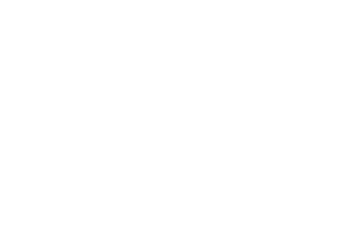

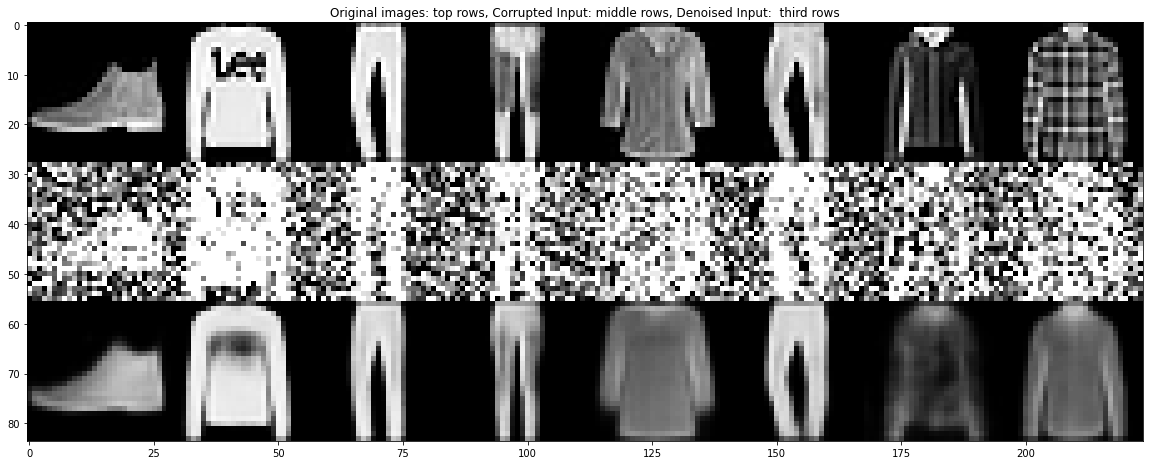

In [ ]:
plt.figure()
plt.axis('off')
plt.figure(figsize=(20,20))
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('fashion_mnist_corrupted_and_denoised.png')
plt.show()

In [ ]:
%ls /content
%cp /content/*.png /content/drive/'My Drive'

denoiser.hdf5  fashion_mnist_corrupted_and_denoised.png  sample_data/
cp: cannot create regular file '/content/drive/My Drive': No such file or directory
